# PREP

In [2]:
import os
import numpy as np
import math
import pandas as pd
import re
from functools import reduce
from collections import OrderedDict
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay, 
    accuracy_score
)
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle,
)

2023-03-24 17:43:42.262767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-24 17:43:43.093738: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-24 17:43:43.094832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-24 17:43:43.120842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-24 17:43:43.121274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-

## TODO remove old code and repetitions

In [4]:
# REPODIR = '/home/lisa-wm/Documents/1_work/1_research/repos/wildlife-experiments'
REPODIR = '/home/wimmerl/projects/wildlife-experiments/'
RESULTDIR = os.path.join(REPODIR, 'results')

CFG = load_json(os.path.join(REPODIR, 'configs/cfg.json'))
LABEL_MAP = load_json(os.path.join(REPODIR, 'data/label_map.json'))
EMPTY_CLASS = LABEL_MAP['empty']
CONFMAT_ARGS = {
    'normalize': 'true',
    'values_format': '.2f',
    'display_labels': list(LABEL_MAP.keys()),
    'xticks_rotation': 'vertical',
    'colorbar': False,
    'cmap': 'Blues',
}
THRESHOLDS = [0, 0.3, 0.5, 0.7, 0.9]
OUR_THRESH = 0.5
ITERATIONS = list(range(9))[1:]
RANDOM_SEEDS = ['123', '456', '789']

## DATA

In [6]:
FILES_INSAMPLE = [
    [
        os.path.join(RESULTDIR, 'passive', t, f) for f in os.listdir(os.path.join(RESULTDIR, 'passive', t)) 
        if 'insample_test' in f
    ] 
    for t in [str(int(100 * ts)) for ts in THRESHOLDS]
]
FILES_OOSAMPLE = [
    os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)), f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'passive', str(int(100 * OUR_THRESH)))) 
    if 'oosample' in f 
]
FILES_ACTIVE_OPTIMAL = [
    os.path.join(RESULTDIR, 'active', 'optimal', f) 
    for f in os.listdir(os.path.join(RESULTDIR, 'active', 'optimal'))
    if 'active_optimal' in f 
]
FILES_ACTIVE_COLDSTART = [os.path.join(RESULTDIR, 'active', 'coldstart', 'entropy', rs) for rs in RANDOM_SEEDS]
FILES_ACTIVE_WARMSTART = [os.path.join(RESULTDIR, 'active', 'warmstart', 'entropy', rs) for rs in RANDOM_SEEDS]

In [7]:
# RESULT_FILE = {**RESULTS_INSAMPLE_TEST_01, **RESULTS_INSAMPLE_TEST_05}
PREDS = 'preds_imgs_ppl'
TRUTH = 'truth_imgs_ppl'

In [8]:
def sort_results(dict_preds, truth):
    ordered_dict = {k: dict_preds[k] for k in sorted(list(dict_preds.keys()))}
    ordered_array = np.concatenate([x.reshape(1, len(LABEL_MAP)) for x in list(ordered_dict.values())])
    ordered_list = [truth[k] for k in [list(dict_preds.keys()).index(i) for i in sorted(list(dict_preds.keys()))]]
    return ordered_array, ordered_list

# IN-SAMPLE

## PERFORMANCE ACROSS THRESHOLDS ON TEST

Using varying thresholds for the MD, how well is our pipeline able to 1) classify images overall, 2) detect empty images correctly?

In [9]:
rows_multiclass_avg, rows_multiclass_se = [], []
rows_empty_avg, rows_empty_se = [], []

for idx, t in enumerate(THRESHOLDS):
    
    results_t = [f for f in FILES_INSAMPLE[idx]]
    accs, precs, recs, fones = [], [], [], []
    accs_empty, precs_empty, recs_empty, fones_empty = [], [], [], []
    precs_nonempty, recs_nonempty, fones_nonempty = [], [], []
    
    for rt in results_t:
        
        r = load_pickle(rt)
        preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r[PREDS], r[TRUTH])
        y_true = truth_imgs_ppl_t
        y_pred = [np.argmax(v) for v in preds_imgs_ppl_t]
        report = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            zero_division=0,
            output_dict=True,
        )
        
        accs.append(report['accuracy'])
        precs.append(report['weighted avg']['precision'])
        recs.append(report['weighted avg']['recall'])
        fones.append(report['weighted avg']['f1-score'])
        
        conf_empty = multilabel_confusion_matrix(y_true, y_pred, labels=[EMPTY_CLASS])
        tn, fp, fn, tp = conf_empty.ravel()
        accs_empty.append((tn + tp) / (tn + fp + fn + tp))
        precs_empty.append(report['empty']['precision'])
        recs_empty.append(report['empty']['recall'])
        fones_empty.append(report['empty']['f1-score'])
        precs_nonempty.append(tn / (tn + fn))
        recs_nonempty.append(tn / (tn + fp))
        fones_nonempty.append(2 * tn / (2 * tn + fn + fp))
        
    accs = np.array(accs)
    precs = np.array(precs)
    recs = np.array(recs)
    fones = np.array(fones)
    rows_multiclass_avg_t = [t]
    rows_multiclass_avg_t.extend(
        [np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]]
    )
    rows_multiclass_avg.append(rows_multiclass_avg_t)
    rows_multiclass_se_t = [t]
    rows_multiclass_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs) / math.sqrt(len(accs)),
                np.std(precs) / math.sqrt(len(precs)),
                np.std(recs) / math.sqrt(len(recs)),
                np.std(fones) / math.sqrt(len(fones))
            ]
            
        ]
        
    )
    rows_multiclass_se.append(rows_multiclass_se_t)
    accs_empty = np.array(accs_empty)
    precs_empty = np.array(precs_empty)
    recs_empty = np.array(recs_empty)
    fones_empty = np.array(fones_empty)
    precs_nonempty = np.array(precs_nonempty)
    recs_nonempty = np.array(recs_nonempty)
    fones_nonempty = np.array(fones_nonempty)
    rows_empty_avg_t = [t]
    rows_empty_avg_t.extend(
        [
            np.round(x, 3) for x in [
                np.mean(accs_empty), 
                np.mean(precs_empty), 
                np.mean(recs_empty), 
                np.mean(fones_empty),
                np.mean(precs_nonempty), 
                np.mean(recs_nonempty), 
                np.mean(fones_nonempty)                
            ]
        ]
    )
    rows_empty_avg.append(rows_empty_avg_t)
    rows_empty_se_t = [t]
    rows_empty_se_t.extend(
        [
            np.round(x, 3) for x in [
                np.std(accs_empty) / math.sqrt(len(accs_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_empty)),
                np.std(recs_empty) / math.sqrt(len(recs_empty)),
                np.std(fones_empty) / math.sqrt(len(fones_empty)),
                np.std(precs_empty) / math.sqrt(len(precs_nonempty)),
                np.std(recs_empty) / math.sqrt(len(recs_nonempty)),
                np.std(fones_empty) / math.sqrt(len(fones_nonempty))
            ]
            
        ]
        
    )
    rows_empty_se.append(rows_empty_se_t)
COLNAMES = ['threshold', 'acc', 'prec', 'rec', 'fone']
COLNAMES_EMPTY = ['threshold', 'acc', 'prec', 'rec', 'fone', 'prec_ne', 'rec_ne', 'fone_ne']
df_ins_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_ins_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)
df_ins_empty_avg = pd.DataFrame(rows_empty_avg, columns=COLNAMES_EMPTY)
df_ins_empty_se = pd.DataFrame(rows_empty_se, columns=COLNAMES_EMPTY)

In [10]:
df_ins_multiclass_avg  # Table 3

,threshold,acc,prec,rec,fone
0,0.0,0.820,0.840,0.820,0.816
1,0.3,0.926,0.922,0.926,0.922
2,0.5,0.924,0.920,0.924,0.920
3,0.7,0.928,0.923,0.928,0.923
4,0.9,0.923,0.917,0.923,0.916


In [11]:
df_ins_empty_avg  # Table 2

,threshold,acc,prec,rec,fone,prec_ne,rec_ne,fone_ne
0,0.0,0.905,0.816,0.881,0.843,0.940,0.875,0.905
1,0.3,0.952,0.947,0.981,0.964,0.963,0.900,0.930
2,0.5,0.949,0.943,0.982,0.962,0.964,0.891,0.926
3,0.7,0.952,0.940,0.990,0.964,0.979,0.885,0.930
4,0.9,0.949,0.934,0.991,0.962,0.981,0.873,0.924


In [12]:
df_ins_multiclass_se

,threshold,acc,prec,rec,fone
0,0.0,0.023,0.013,0.023,0.020
1,0.3,0.002,0.002,0.002,0.002
2,0.5,0.003,0.003,0.003,0.003
3,0.7,0.001,0.002,0.001,0.001
4,0.9,0.001,0.001,0.001,0.001


In [13]:
df_ins_empty_se

,threshold,acc,prec,rec,fone,prec_ne,rec_ne,fone_ne
0,0.0,0.006,0.042,0.047,0.040,0.042,0.047,0.040
1,0.3,0.000,0.000,0.001,0.000,0.000,0.001,0.000
2,0.5,0.002,0.001,0.003,0.002,0.001,0.003,0.002
3,0.7,0.001,0.000,0.001,0.001,0.000,0.001,0.001
4,0.9,0.001,0.001,0.001,0.000,0.001,0.001,0.000


## PERFORMANCE

In [33]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_INSAMPLE[1]]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
print(  # Figure 3
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
    )
)

               precision    recall  f1-score   support

        empty       0.95      0.98      0.96      7086
european_hare       0.88      0.69      0.77       192
       others       0.61      0.43      0.51       432
     red_deer       1.00      0.71      0.83        21
      red_fox       0.88      0.70      0.78       297
 red_squirrel       0.92      0.79      0.85       141
     roe_deer       0.91      0.93      0.92      2712
    wild_boar       0.82      0.47      0.60        87

     accuracy                           0.93     10968
    macro avg       0.87      0.71      0.78     10968
 weighted avg       0.92      0.93      0.92     10968



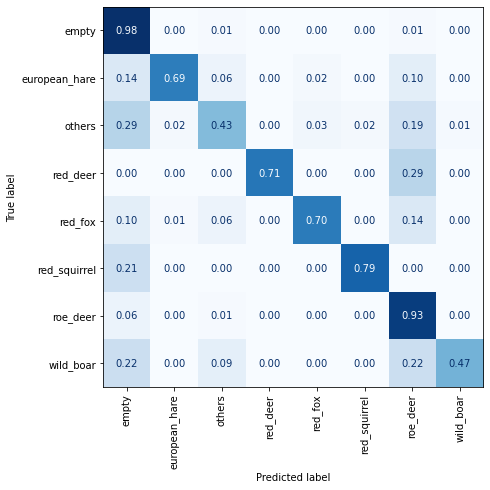

In [34]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
plt.rcParams['figure.figsize'] = (7, 7)
plt.savefig('figures/cm_insample.eps', bbox_inches='tight')
plt.savefig('figures/cm_insample.png')

# OUT-OF-SAMPLE

## PERFORMANCE

In [16]:
rows_multiclass_avg, rows_multiclass_se = [], []
accs, precs, recs, fones = [], [], [], []

for r in [f for f in FILES_OOSAMPLE]:
    r = load_pickle(r)
    preds_imgs_ppl, truth_imgs_ppl = sort_results(r[PREDS], r[TRUTH])
    y_true = truth_imgs_ppl
    y_pred = [np.argmax(v) for v in preds_imgs_ppl]
    report = classification_report(
        y_true=y_true, 
        y_pred=y_pred,
        target_names=list(LABEL_MAP.keys()),
        zero_division=0,
        output_dict=True,
    )
    accs.append(report['accuracy'])
    precs.append(report['weighted avg']['precision'])
    recs.append(report['weighted avg']['recall'])
    fones.append(report['weighted avg']['f1-score'])
accs = np.array(accs)
precs = np.array(precs)
recs = np.array(recs)
fones = np.array(fones)
rows_multiclass_avg.append([np.round(x, 3) for x in [np.mean(accs), np.mean(precs), np.mean(recs), np.mean(fones)]])
rows_multiclass_se.append(
    [
        np.round(x, 3) for x in [
            np.std(accs) / math.sqrt(len(accs)),
            np.std(precs) / math.sqrt(len(precs)),
            np.std(recs) / math.sqrt(len(recs)),
            np.std(fones) / math.sqrt(len(fones))
        ]
        
    ]

)
COLNAMES = ['acc', 'prec', 'rec', 'fone']
df_oos_multiclass_avg = pd.DataFrame(rows_multiclass_avg, columns=COLNAMES)
df_oos_multiclass_se = pd.DataFrame(rows_multiclass_se, columns=COLNAMES)

In [17]:
acc_al_lower_limit, rec_al_lower_limit = rows_multiclass_avg[0][0], rows_multiclass_avg[0][1]

In [18]:
df_multiclass_avg = pd.concat(
    [df_ins_multiclass_avg.loc[df_ins_multiclass_avg['threshold'] == OUR_THRESH], df_oos_multiclass_avg]
)
df_multiclass_avg.index = ['ins', 'oos']

In [19]:
df_multiclass_se = pd.concat(
    [df_ins_multiclass_se.loc[df_ins_multiclass_se['threshold'] == OUR_THRESH], df_oos_multiclass_se]
)
df_multiclass_se.index = ['ins', 'oos']

In [20]:
df_multiclass_avg.drop(['threshold'], axis=1)  # Table 5

,acc,prec,rec,fone
ins,0.924,0.920,0.924,0.920
oos,0.881,0.874,0.881,0.873


In [21]:
df_multiclass_se.drop(['threshold'], axis=1)

,acc,prec,rec,fone
ins,0.003,0.003,0.003,0.003
oos,0.001,0.001,0.001,0.001


In [23]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_OOSAMPLE]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))

print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 

               precision    recall  f1-score   support

        empty       0.94      0.96      0.95      6414
european_hare       0.60      0.41      0.49       111
       others       0.35      0.23      0.27       477
     red_deer       1.00      0.03      0.05        36
      red_fox       0.28      0.59      0.38        51
 red_squirrel       0.14      0.67      0.23         6
     roe_deer       0.85      0.90      0.88      3126
    wild_boar       0.88      0.51      0.65       468

     accuracy                           0.88     10689
    macro avg       0.63      0.54      0.49     10689
 weighted avg       0.88      0.88      0.87     10689



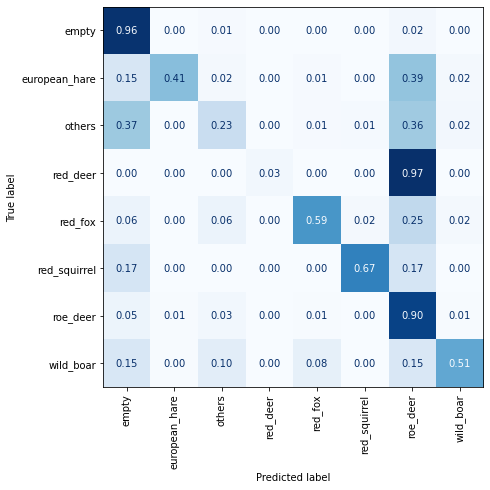

In [24]:
ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
plt.rcParams['figure.figsize'] = (7, 7)
plt.savefig('figures/cm_oosample.eps')
plt.savefig('figures/cm_oosample.png')

## ACTIVE LEARNING

In [29]:
reports, conf_matrices = [], []
y_trues, y_preds = np.empty(0), np.empty(0)
for r in [load_pickle(f) for f in FILES_ACTIVE_OPTIMAL]:
    preds_imgs_ppl_t, truth_imgs_ppl_t = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
    y_trues = np.concatenate((y_trues, truth_imgs_ppl_t))
    y_preds = np.concatenate((y_preds, [np.argmax(v) for v in preds_imgs_ppl_t]))
report_dict = classification_report(
    y_true=np.array(y_trues), 
    y_pred=np.array(y_preds),
    target_names=list(LABEL_MAP.keys()),
    output_dict=True,
    zero_division=0
)
acc_al_upper_limit, rec_al_upper_limit = report_dict['accuracy'], report_dict['weighted avg']['precision']

               precision    recall  f1-score   support

        empty       0.94      0.98      0.96      6414
european_hare       0.94      0.61      0.74       111
       others       0.76      0.37      0.50       477
     red_deer       0.74      0.47      0.58        36
      red_fox       0.86      0.73      0.79        51
 red_squirrel       0.83      0.83      0.83         6
     roe_deer       0.91      0.93      0.92      3126
    wild_boar       0.93      0.81      0.86       468

     accuracy                           0.93     10689
    macro avg       0.86      0.72      0.77     10689
 weighted avg       0.92      0.93      0.92     10689



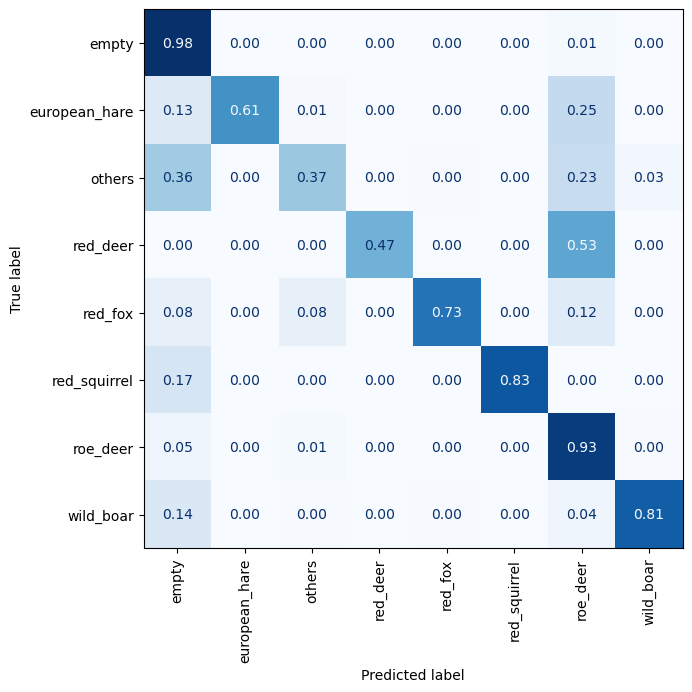

In [45]:
print(  # Figure 5
    classification_report(
        y_true=np.array(y_trues), 
        y_pred=np.array(y_preds),
        target_names=list(LABEL_MAP.keys()),
        zero_division=0
    )

) 

# N_OBS !!!!

In [25]:
# compute relative sample size per iteration (sizes hard-coded for training)
n_obs = 10020
init_batches = [0] + [2**x for x in range(7, 13)]
batch_sizes = init_batches + [n_obs - sum(init_batches)]
batch_sizes_cs = np.cumsum([x / n_obs for x in batch_sizes])

In [26]:
ITERATION_EXTRACT = 6

{'empty': {'precision': 0.9398203592814371, 'recall': 0.9787963829123791, 'f1-score': 0.9589124789980144, 'support': 6414}, 'european_hare': {'precision': 0.9333333333333333, 'recall': 0.5045045045045045, 'f1-score': 0.6549707602339181, 'support': 111}, 'others': {'precision': 0.717391304347826, 'recall': 0.34591194968553457, 'f1-score': 0.46676096181046667, 'support': 477}, 'red_deer': {'precision': 0.8695652173913043, 'recall': 0.5555555555555556, 'f1-score': 0.6779661016949152, 'support': 36}, 'red_fox': {'precision': 0.8478260869565217, 'recall': 0.7647058823529411, 'f1-score': 0.8041237113402062, 'support': 51}, 'red_squirrel': {'precision': 0.75, 'recall': 0.5, 'f1-score': 0.6, 'support': 6}, 'roe_deer': {'precision': 0.9023787457522398, 'recall': 0.9344209852847088, 'f1-score': 0.918120383466918, 'support': 3126}, 'wild_boar': {'precision': 0.9242053789731052, 'recall': 0.8076923076923077, 'f1-score': 0.8620296465222349, 'support': 468}, 'accuracy': 0.9224436336420619, 'macro av

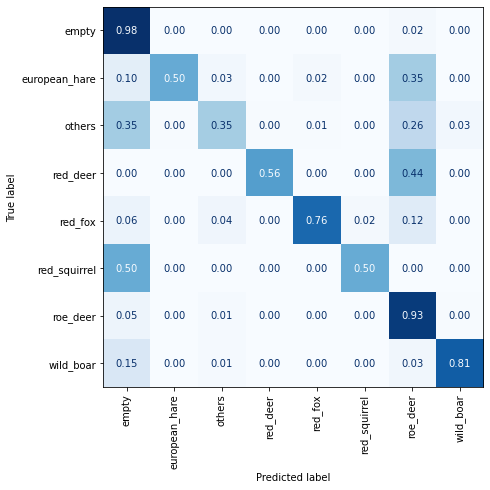

In [27]:
acc_coldstart_avg, rec_coldstart_avg = [], []
acc_coldstart_se, rec_coldstart_se = [], []
acc_warmstart_avg, rec_warmstart_avg = [], []
acc_warmstart_se, rec_warmstart_se = [], []

for i in ITERATIONS:
    acc_coldstart, rec_coldstart = [], []
    acc_warmstart, rec_warmstart = [], []
    y_trues, y_preds = np.empty(0), np.empty(0)
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_COLDSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS)
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_cs = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_coldstart.append(report_dict_cs['accuracy'])
        rec_coldstart.append(report_dict_cs['weighted avg']['precision'])
        if i == ITERATION_EXTRACT:
            y_trues = np.concatenate((y_trues, y_true))
            y_preds = np.concatenate((y_preds, y_pred))
    if i == ITERATION_EXTRACT:
        ConfusionMatrixDisplay.from_predictions(y_true=np.array(y_trues), y_pred=np.array(y_preds), **CONFMAT_ARGS)
        plt.rcParams['figure.figsize'] = (7, 7)
        plt.savefig('figures/cm_active.eps')
        plt.savefig('figures/cm_active.png')
        print(
            classification_report(
                y_true=y_trues, 
                y_pred=y_preds,
                target_names=list(LABEL_MAP.keys()),
                output_dict=True,
                zero_division=0
            )
        )
    for r in [
        load_pickle(f) for f in [
            os.path.join(FILES_ACTIVE_WARMSTART[idx], f'results_iteration_{i}.pkl') 
            for idx, _ in enumerate(RANDOM_SEEDS) # !!!!
        ]
    ]:
        preds_imgs_ppl, truth_imgs_ppl = sort_results(r['preds_imgs_ppl'], r['truth_imgs_ppl'])
        y_true = truth_imgs_ppl
        y_pred = [np.argmax(v) for v in preds_imgs_ppl]
        report_dict_ws = classification_report(
            y_true=y_true, 
            y_pred=y_pred,
            target_names=list(LABEL_MAP.keys()),
            output_dict=True,
            zero_division=0
        )
        acc_warmstart.append(report_dict_ws['accuracy'])
        rec_warmstart.append(report_dict_ws['weighted avg']['precision'])
    acc_coldstart = np.array(acc_coldstart)
    rec_coldstart = np.array(rec_coldstart)
    acc_coldstart_avg.append(np.mean(acc_coldstart))
    rec_coldstart_avg.append(np.mean(rec_coldstart))
    acc_coldstart_se.append(np.std(acc_coldstart) / math.sqrt(len(acc_coldstart)))
    rec_coldstart_se.append(np.std(rec_coldstart) / math.sqrt(len(rec_coldstart)))
    acc_warmstart = np.array(acc_warmstart)
    rec_coldstart = np.array(rec_warmstart)
    acc_warmstart_avg.append(np.mean(acc_warmstart))
    rec_warmstart_avg.append(np.mean(rec_warmstart))
    acc_warmstart_se.append(np.std(acc_warmstart) / math.sqrt(len(acc_warmstart)))
    rec_warmstart_se.append(np.std(rec_warmstart) / math.sqrt(len(rec_warmstart)))        

In [30]:
acc_coldstart_avg[-1] = acc_al_upper_limit
rec_coldstart_avg[-1] = rec_al_upper_limit
acc_warmstart_avg[-1] = acc_al_upper_limit
rec_warmstart_avg[-1] = rec_al_upper_limit

In [31]:
# create data for plot
al_perf_acc = {
    'relative_size': batch_sizes_cs,
    'acc_lower_limit': [acc_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'acc_upper_limit': [acc_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'acc_coldstart': acc_coldstart_avg,
    'se_coldstart': acc_coldstart_se,
    'acc_warmstart': acc_warmstart_avg,
    'se_warmstart': acc_warmstart_se,
}
al_perf_rec = {
    'relative_size': batch_sizes_cs,
    'rec_lower_limit': [rec_al_lower_limit for _ in range(len(acc_coldstart_avg))],
    'rec_upper_limit': [rec_al_upper_limit for _ in range(len(acc_coldstart_avg))],
    'rec_coldstart': rec_coldstart_avg,
    'rec_coldstart_se': rec_coldstart_se,
#     'rec_warmstart': rec_warmstart
}
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
al_perf_rec_pd = pd.DataFrame(al_perf_rec)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


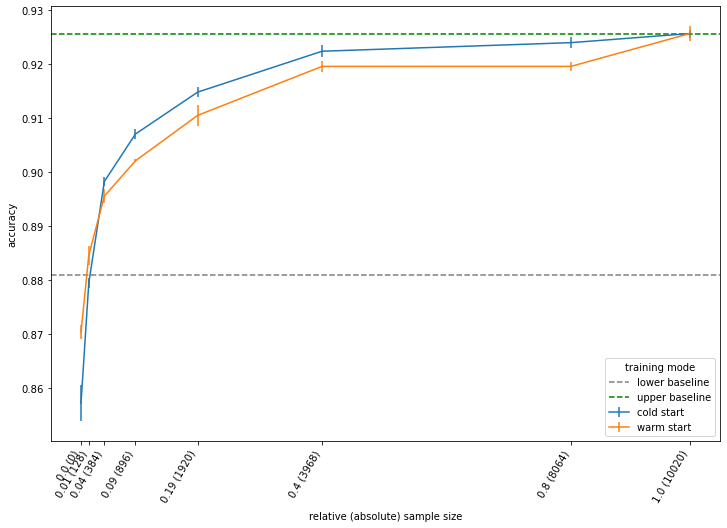

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_coldstart'], al_perf_acc_pd['se_coldstart'])
ax.errorbar(al_perf_acc_pd['relative_size'], al_perf_acc_pd['acc_warmstart'], al_perf_acc_pd['se_warmstart'])
ax.set_xlabel('relative (absolute) sample size')
ax.set_xticks(al_perf_acc_pd['relative_size'])
ax.set_xticklabels(
    [
        f' {round(i, 2)} ({round(j, 2)})' 
        for i, j in zip(al_perf_acc_pd['relative_size'], np.cumsum(batch_sizes))
    ],
    rotation=60,
    ha='right'
)
ax.set_ylabel('accuracy')
# ax2 = ax.twiny()
# ax2.set_xticks(al_perf_acc_pd['relative_size'])
# ax2.set_xticklabels(batch_sizes, rotation=45)
# ax2.set_xlabel('absolute sample size')
# ax.set_xscale('log')
ax.axhline(acc_al_lower_limit,color='gray',ls='--')
ax.axhline(acc_al_upper_limit,color='green',ls='--')
ax.legend(
    title='training mode', 
    loc='lower right', 
    labels=['lower baseline', 'upper baseline', 'cold start', 'warm start']
)
plt.rcParams['figure.figsize'] = (7, 7)
plt.savefig('figures/active_learning.eps')
plt.savefig('figures/active_learning.png')